<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/03_arx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW3 objectives - ARX model estimate:
- Load data SteamEng.mat
- Estimate and ARX model with Pressure as input and Speed as
output.
- Once you fit the model, computed the predicted (estimated) output and
error of the fit.
- Select the best model order Q and P using cross validation.
- Display input on one subplot, and on a different subplot, the original
output and estimated output.

In [ ]:
import numpy as np
from scipy import signal, stats
from matplotlib import pyplot as plt

from scipy.linalg import toeplitz
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold


from tqdm import tqdm

In [ ]:
def grab_file(filename):
    import requests
    import io

    PARENT = 'https://parralab.org/teaching/biomed-dsp/'
    FILENAME = filename
    FULLPATH = PARENT+FILENAME
    print(FULLPATH)

    response = requests.get(FULLPATH)
    data_stream = io.BytesIO(response.content)

    return data_stream


def grab_mat(mat_file):
    from scipy import io as sio

    data_stream = grab_file(mat_file)
    mat_contents = sio.loadmat(data_stream)

    return mat_contents


def grab_wav(wav_file):
    from scipy import io as sio

    audio_bytes = grab_file(wav_file)
    fs, data = sio.wavfile.read(audio_bytes)

    return fs, data

In [ ]:
steam = grab_mat('SteamEng.mat')

https://parralab.org/teaching/biomed-dsp/SteamEng.mat


In [ ]:
steam.keys()

dict_keys(['__header__', '__version__', '__globals__', 'GenVolt', 'MagVolt', 'Pressure', 'Speed'])

In [ ]:
pressure = steam['Pressure'].T[0]
speed = steam['Speed'].T[0]

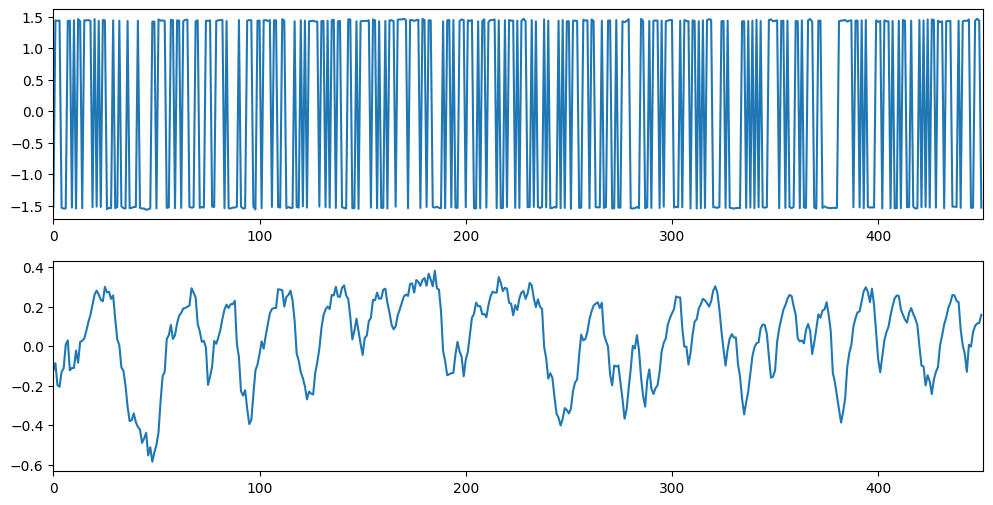

In [ ]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax1.plot(pressure)
ax1.set_xlim(0,len(pressure))

ax2.plot(speed)
ax2.set_xlim(0, len(speed))

plt.show()

In [ ]:
pressure.shape

(451,)

# ARX/OE model estimates

ARX : $ \hat{y}[n] = -\sum_{k=1}^{P} a[k]y[n-k] + \sum_{k=0}^{Q} b[k]x[n-k] $

regression form ... $ y[n] = (-a[1])y[n-1] + (-a[2])y[n-2] + \dots + (-a[P])y[n-P] + (b[0])x[n] + (b[1])x[n-1] + \dots + (b[Q])x[n-Q] $

- y[n-k] ... past outputs
- x[n-k] ... past and present inputs

- P order of AR part - how many past outputs to use
- Q order of X part - how many past inputs to use



OE : $ \hat{y}[n] = -\sum_{k=1}^{P} a[k]\hat{y}[n-k] + \sum_{k=0}^{Q} b[k]x[n-k] $

In [ ]:
def arx_regressors(y, x, p, q):
    n_start = max(p, q)
    n_samples = len(y)
    y_target = y[n_start:]
    n_rows = len(y_target)

    # past y vals ... artifact reduction
    y_col = -y[n_start-1:n_start-1+n_rows]
    y_row = -y[n_start-p:n_start][::-1]
    Y_matrix = toeplitz(y_col, r=y_row)

    # past/present x vals
    x_col = x[n_start:n_start+n_rows]
    x_row = x[n_start-q:n_start+1][::-1]
    X_matrix = toeplitz(x_col, r=x_row)

    M = np.hstack([Y_matrix, X_matrix])

    return M, y_target


# OE model ... use past PREDICTIONS
# couldn't find a direct implementation of matlab oe in python
def oe_model(coeffs, x, p, q):
    # feed in arx model output -- check this
    a_coeffs = coeffs[:p]
    b_coeffs = coeffs[p:]

    n_start = max(p, q)
    y_pred = np.zeros(len(x))

    for n in range(n_start, len(x)):
        # past y pred (AR)
        past_y_terms = -np.sum(a_coeffs * y_pred[n-p:n][::-1])
        # past/present x vals
        past_x_terms = np.sum(b_coeffs * x[n-q:n+1][::-1])
        y_pred[n] = past_y_terms + past_x_terms

    return y_pred


def oe_mse(coeffs, y_true, x, p, q):
    # need this for scipy minimize call below...
    n_start = max(p,q)
    y_pred = oe_model(coeffs, x, p, q)
    return np.mean((y_true[n_start:] - y_pred[n_start:])**2)

In [ ]:
# x = np.linspace(1.01, 1.99, 100)
# y = np.linspace(2.01, 2.99, 100)

# zM, zy = arx_regressors(y,x,5,5)
# zM[:,0]

## Find best P&Q

In [ ]:
p_range = range(1,31)
q_range = range(1,31)

kf = KFold(n_splits=5)

train_mse = np.zeros((len(q_range), len(p_range)))
test_mse = np.zeros((len(q_range), len(p_range)))


for i, p in enumerate(tqdm(p_range)):
    for j, q in enumerate(q_range):
        fold_train_mses = []
        fold_test_mses = []

        for train_idx, test_idx in kf.split(speed):
            y_train, y_test = speed[train_idx], speed[test_idx]
            x_train, x_test = pressure[train_idx], pressure[test_idx]

            M_train, y_targ_train = arx_regressors(y_train, x_train, p, q)
            M_test, y_targ_test = arx_regressors(y_test, x_test, p, q)

            b_hat, _, _, _ = np.linalg.lstsq(M_train, y_targ_train)
            y_pred_train = M_train @ b_hat
            y_pred_test = M_test @ b_hat

            current_train_mse = np.mean((y_targ_train - y_pred_train)**2)
            current_test_mse = np.mean((y_targ_test - y_pred_test)**2)
            fold_train_mses.append(current_train_mse)
            fold_test_mses.append(current_test_mse)

        train_mse[i, j] = np.mean(fold_train_mses)  # p/q (i/j) combo avg per fold
        test_mse[i, j] = np.mean(fold_test_mses)

100%|██████████| 30/30 [00:04<00:00,  6.02it/s]


In [ ]:
np.argmin(test_mse)

np.int64(48)

## ARX

In [ ]:
best_idx = np.unravel_index(np.argmin(test_mse), test_mse.shape)
best_p = p_range[best_idx[0]]
best_q = q_range[best_idx[1]]

# refit w best p/q
M, y = arx_regressors(speed, pressure, best_p, best_q)
b_hat, _, _, _ = np.linalg.lstsq(M, y)

y_hat_arx = M@b_hat
error_arx = y - y_hat_arx

n_start_final = max(best_p, best_q)
y_hat_arx_full = np.concatenate([np.nan+np.zeros(max(best_p, best_q)), y_hat_arx])

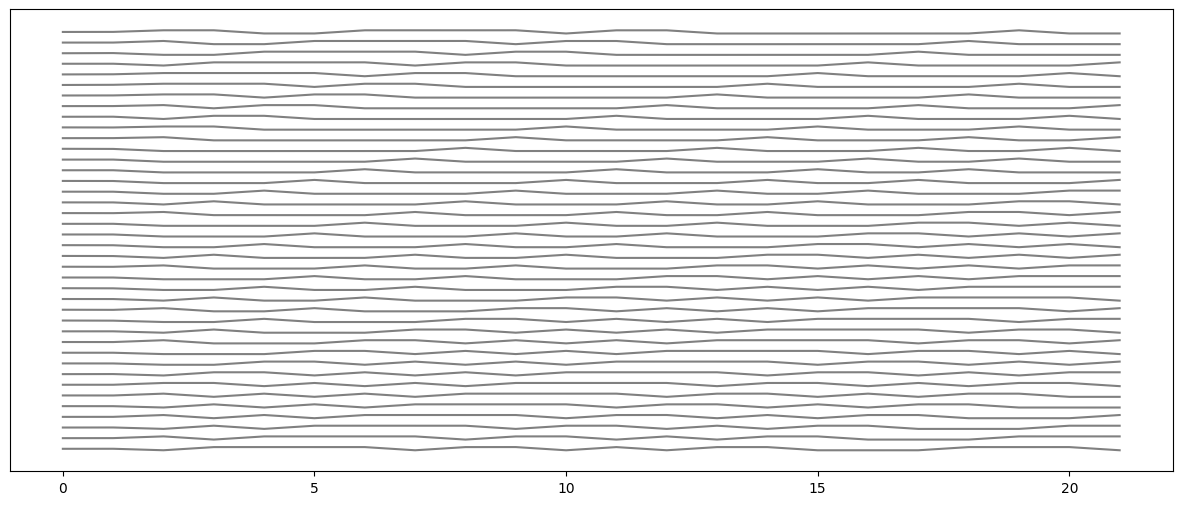

In [ ]:
plt.figure(figsize=(15,6))
for i in range(len(M[20:60])):
    plt.plot(M[i]+(i*10), c="gray")
plt.yticks([])
plt.show()

# plt.imshow(M[:80], aspect='auto')
# plt.show()

## OE

In [ ]:
# l-bfgs-b method https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
result = minimize(oe_mse, b_hat, args=(speed, pressure, best_p, best_q), method='L-BFGS-B')  # documentation reco - bounded constraints?
theta_oe = result.x
y_hat_oe_full = oe_model(theta_oe, pressure, best_p, best_q) # full len

# theta_oe

In [ ]:
len(y_hat_arx_full) == len(y_hat_oe_full) == len(speed)

True

best_p (AR ord.):  2
best_q (X ord.):   19
min test MSE:      0.0017


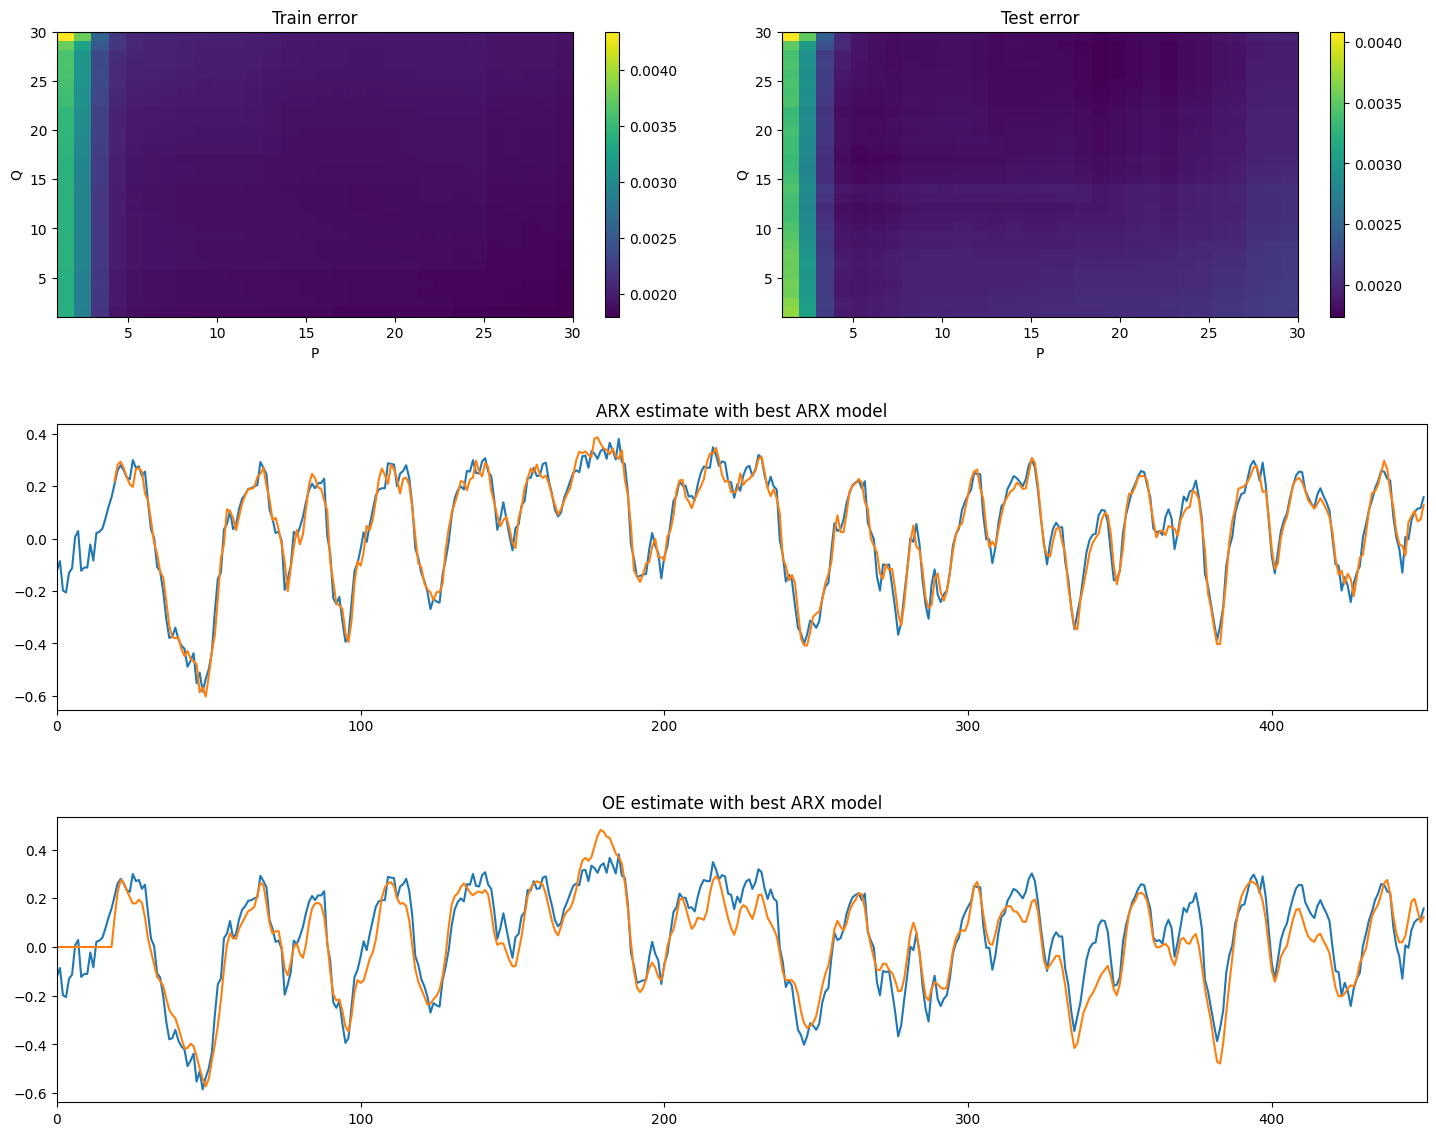

In [ ]:
print(f"best_p (AR ord.):  {best_p}")
print(f"best_q (X ord.):   {best_q}")
print(f"min test MSE:      {test_mse.min():.4f}")

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2)

# heatmaps
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# arx plot
ax3 = fig.add_subplot(gs[1, :])
# oe plot
ax4 = fig.add_subplot(gs[2, :])


# error - train
im1 = ax1.imshow(train_mse, aspect='auto', extent=[1,max(p_range),1,max(q_range)], vmin=np.min(train_mse), vmax=np.max(train_mse))
ax1.set_title('Train error')
ax1.set_xlabel('P')
ax1.set_ylabel('Q')
fig.colorbar(im1, ax=ax1)

# error - test
im2 = ax2.imshow(test_mse, aspect='auto', extent=[1,max(p_range),1,max(q_range)], vmin=np.min(test_mse), vmax=np.max(test_mse))
ax2.set_title('Test error')
ax2.set_xlabel('P')
ax2.set_ylabel('Q')
fig.colorbar(im2, ax=ax2)

# arx
ax3.plot(speed, label='speed')
ax3.plot(y_hat_arx_full, label='ARX est')
ax3.set_title('ARX estimate with best ARX model')
ax3.set_xlim(0, len(speed))

# oe
ax4.plot(speed, label='speed')
ax4.plot(y_hat_oe_full, label='OE est')
ax4.set_title('OE estimate with best ARX model')
ax4.set_xlim(0, len(speed))

plt.tight_layout(pad=3.0)
plt.show()